In [3]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report, RocCurveDisplay
)
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns


In [4]:
df = pd.read_csv("../data/processed_data.csv")
print(df.shape)
df.head()


(7043, 31)


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,...,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,0,1,0,-1.277445,0,1,-1.160323,-0.994242,0,...,False,False,False,False,False,False,False,False,True,False
1,1,0,0,0,0.066327,1,0,-0.259629,-0.173244,0,...,False,False,False,False,False,True,False,False,False,True
2,1,0,0,0,-1.236724,1,1,-0.362660,-0.959674,1,...,False,False,False,False,False,False,False,False,False,True
3,1,0,0,0,0.514251,0,0,-0.746535,-0.194766,0,...,True,False,False,False,False,True,False,False,False,False
4,0,0,0,0,-1.236724,1,1,0.197365,-0.940470,1,...,False,False,False,False,False,False,False,False,True,False


In [5]:
X = df.drop("Churn", axis=1)
y = df["Churn"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


In [6]:
logreg = Pipeline([
    ("clf", LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42))
])

logreg.fit(X_train, y_train)
y_pred_log = logreg.predict(X_test)
y_proba_log = logreg.predict_proba(X_test)[:, 1]


In [7]:
def evaluate_model(y_true, y_pred, y_proba):
    print(classification_report(y_true, y_pred))
    print(f"ROC AUC: {roc_auc_score(y_true, y_proba):.4f}")
    
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()
    
    RocCurveDisplay.from_predictions(y_true, y_proba)
    plt.title("ROC Curve")
    plt.show()


📌 Logistic Regression Performance:
              precision    recall  f1-score   support

           0       0.90      0.72      0.80      1035
           1       0.51      0.78      0.61       374

    accuracy                           0.74      1409
   macro avg       0.70      0.75      0.71      1409
weighted avg       0.80      0.74      0.75      1409

ROC AUC: 0.8417


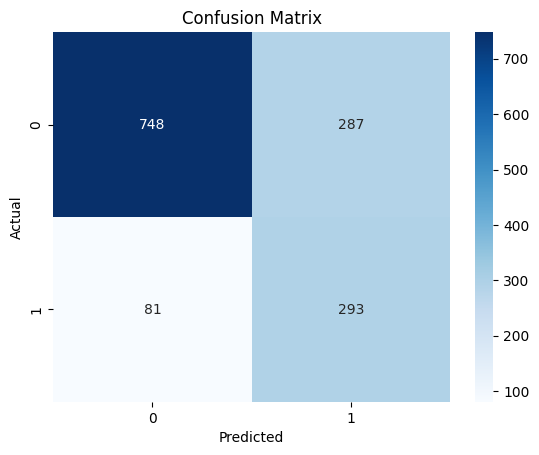

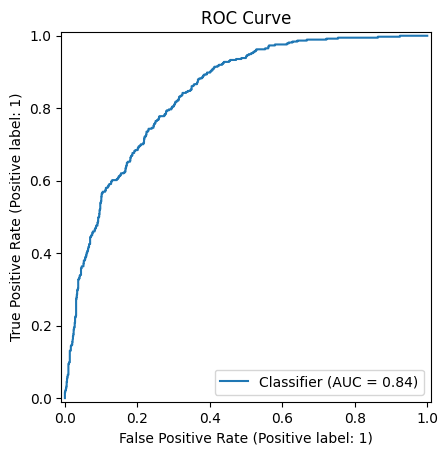

In [8]:
print("📌 Logistic Regression Performance:")
evaluate_model(y_test, y_pred_log, y_proba_log)


📌 Random Forest Performance:
              precision    recall  f1-score   support

           0       0.90      0.75      0.82      1035
           1       0.53      0.78      0.63       374

    accuracy                           0.76      1409
   macro avg       0.72      0.76      0.72      1409
weighted avg       0.80      0.76      0.77      1409

ROC AUC: 0.8434


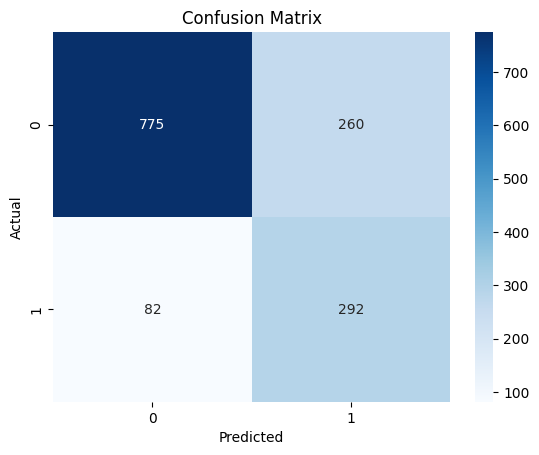

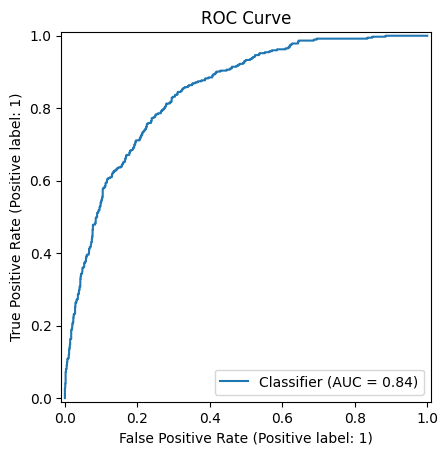

In [9]:
rf = Pipeline([
    ("clf", RandomForestClassifier(n_estimators=200, max_depth=8,
                                   class_weight="balanced", random_state=42))
])

rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:, 1]

print("📌 Random Forest Performance:")
evaluate_model(y_test, y_pred_rf, y_proba_rf)


📌 XGBoost Performance:
              precision    recall  f1-score   support

           0       0.89      0.77      0.82      1035
           1       0.53      0.73      0.61       374

    accuracy                           0.76      1409
   macro avg       0.71      0.75      0.72      1409
weighted avg       0.79      0.76      0.77      1409

ROC AUC: 0.8325


/Users/nimralatif/Desktop/Portfolio/Customer Churn Prediction System/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:18:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


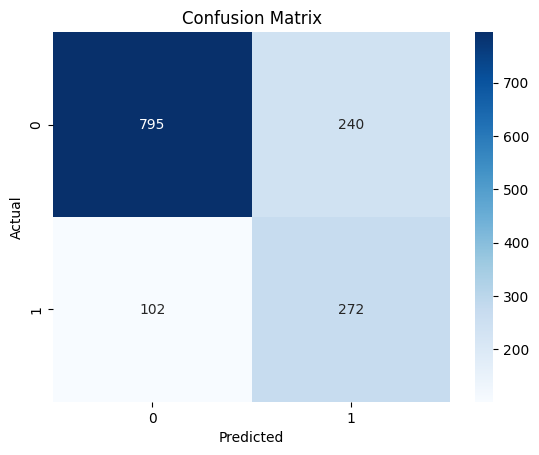

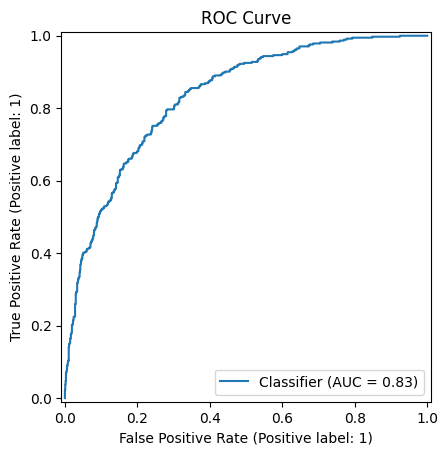

In [10]:
xgb_clf = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    scale_pos_weight=(y == 0).sum() / (y == 1).sum(),  # balance classes
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

xgb_clf.fit(X_train, y_train)
y_pred_xgb = xgb_clf.predict(X_test)
y_proba_xgb = xgb_clf.predict_proba(X_test)[:, 1]

print("📌 XGBoost Performance:")
evaluate_model(y_test, y_pred_xgb, y_proba_xgb)


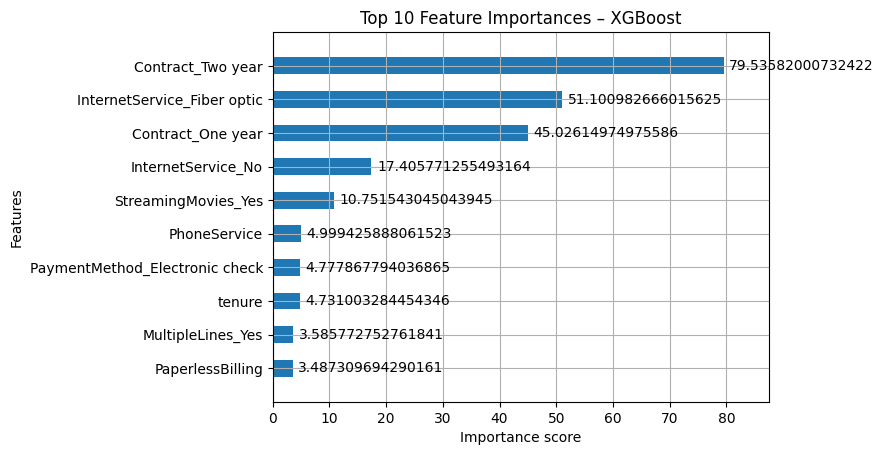

In [11]:
xgb.plot_importance(xgb_clf, max_num_features=10, importance_type='gain', height=0.5)
plt.title("Top 10 Feature Importances – XGBoost")
plt.show()
